# Using Snorkel to Extract Education of Actresses and Actors

<sub>Content of this notebook was prepared by Basel Shbita (shbita@usc.edu) as part of the class <u>CSCI 563/INF 558: Building Knowledge Graphs</u> during Spring 2020 at University of Southern California (USC).</sub>

**Notes**: 
- You are supposed to write your code or modify our code in any cell starting with `# ** STUDENT CODE`.
- Much content of this notebook was borrowed from Snorkel Introduction Tutorial

State-of-the-art extraction techniques require massive labeled training set but it is costly to obtain. To overcome this problem, Snorkel helps rapidly create training sets using the new data programming paradigm. To start, developers focus on writing a set of labeling functions, which are just scripts that programmatically label data. The resulting labels are noisy, but Snorkel uses a generative model to learn how to use those labeling functions to label more data. The new labeled data now can be used to train high-quality end models.

**In summary, in this task, you will first manually label 99 documents and use these labeled data as a development set to create your own labeling functions. Then, you will train a generative model to label 1025 documents in training set. Finally, you will train a discriminative model (Bi-LSTM) to produce your final extraction model!**

## Prepare environment

Lets install the packages we will use

In [ ]:
!pip install -r requirements.txt

We will work with Snorkel version 0.7 (Beta), we can retrieve it by running the following commands:

In [ ]:
!curl -L "https://github.com/snorkel-team/snorkel/archive/v0.7.0-beta.tar.gz" -o snorkel_v0_7_0.tar.gz

Now let's uncompress the package and install Snorkel

In [ ]:
!tar -xvzf snorkel_v0_7_0.tar.gz

In [ ]:
!pip install snorkel-0.7.0-beta/

## Creating a development set

Before you proceed with task 1.1, we need to preprocess our documents using `Snorkel` utilities, parsing them into a simple hierarchy of component parts of our input data, which we refer as _contexts_. We'll also create _candidates_ out of these contexts, which are the objects we want to classify, in this case, possible mentions of schools and colleges that the cast have attended. Finally, we'll load some gold labels for evaluation.

All of this preprocessed input data is saved to a database. In Snorkel, if no database is specified, then a SQLite database at `./snorkel.db` is created by default -- so no setup is needed here!

In [1]:
# ** STUDENT CODE

import numpy as np, os
from pathlib import Path

from snorkel import SnorkelSession
from snorkel.parser import TSVDocPreprocessor, CorpusParser
from snorkel.parser.spacy_parser import Spacy
from snorkel.models import Document, Sentence, candidate_subclass
from snorkel.viewer import SentenceNgramViewer
from snorkel.annotations import LabelAnnotator, load_gold_labels

from utils import reload_external_labels, save_gold_labels, save_predicted_relations, \
     save_gold_relations, get_dev_doc_ids, get_test_doc_ids, get_gold_labels, number_of_people

# TODO: Set location where you store your homework 5 files
if 'HW_DIR' not in os.environ:
    # HW_DIR = Path("/.../Homework05")
    HW_DIR = Path(os.getcwd())
else:
    HW_DIR = Path(os.environ['HW_DIR'])
    assert HW_DIR.exists()

**Initializing a `SnorkelSession`**

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

session = SnorkelSession()

**Loading the Corpus**

Next, we load and pre-process the corpus of documents.

In [3]:
doc_preprocessor = TSVDocPreprocessor(HW_DIR / 'cast_bios.tsv')

**Running a `CorpusParser`**

We'll use [Spacy](https://spacy.io/), an NLP preprocessing tool, to split our documents into sentences and tokens, and provide named entity annotations.

In [4]:
corpus_parser = CorpusParser(parser=Spacy())
%time corpus_parser.apply(doc_preprocessor)

Clearing existing...
Running UDF...
CPU times: user 36.1 s, sys: 1.63 s, total: 37.7 s
Wall time: 37.8 s


We can then use simple database queries (written in the syntax of [SQLAlchemy](http://www.sqlalchemy.org/), which Snorkel uses) to check how many documents and sentences were parsed:

In [5]:
print("Documents:", session.query(Document).count())
print("Sentences:", session.query(Sentence).count())

Documents: 1423
Sentences: 8137


**Generating Candidates**

The next step is to extract _candidates_ from our corpus. A `Candidate` in Snorkel is an object for which we want to make a prediction. In this case, the candidates are pairs of person and organization mentioned in sentences.

The [Spacy](https://spacy.io/) parser we used performs _named entity recognition_ for us. Next, we'll split up the documents into train, development, and test splits; and collect the associated sentences.

In [6]:
Education = candidate_subclass('Education', ['person', 'organization'])

In [7]:
from snorkel.candidates import Ngrams, CandidateExtractor
from snorkel.matchers import PersonMatcher, OrganizationMatcher

ngrams         = Ngrams(n_max=7)
person_matcher = PersonMatcher(longest_match_only=True)
org_matcher    = OrganizationMatcher(longest_match_only=True)
cand_extractor = CandidateExtractor(Education, [ngrams, ngrams], [person_matcher, org_matcher])

In [8]:
docs = session.query(Document).order_by(Document.name).all()

dev_docs = get_dev_doc_ids(HW_DIR / "cast.dev.txt")
test_docs = get_test_doc_ids(HW_DIR / "cast.test.txt")

train_sents = set()
dev_sents   = set()
test_sents  = set()

for doc in docs:
    sents = (s for s in doc.sentences if number_of_people(s) <= 5)
    if doc.name in dev_docs:
        dev_sents.update(sents)
    elif doc.name in test_docs:
        test_sents.update(sents)
    else:
        train_sents.update(sents)
        
print("Number of dev sents:", len(dev_sents))
print("Number of train sents:", len(train_sents))
print("Number of test sents:", len(test_sents))

Number of dev sents: 591
Number of train sents: 5711
Number of test sents: 1808


Finally, we'll apply the candidate extractor to the three sets of sentences. The results will be persisted in the database backend.

In [9]:
%%time
for i, sents in enumerate([train_sents, dev_sents, test_sents]):
    cand_extractor.apply(sents, split=i)
    print("Number of candidates:", session.query(Education).filter(Education.split == i).count())

Clearing existing...
Running UDF...
[========================================] 100%

Number of candidates: 2074
Clearing existing...
Running UDF...
[========================================] 100%

Number of candidates: 227
Clearing existing...
Running UDF...
[========================================] 100%

Number of candidates: 537
CPU times: user 25.8 s, sys: 397 ms, total: 26.2 s
Wall time: 26.1 s


## Task 1.1. Label 99 documents in development set

In this task, you will use `SentenceNgramViewer` to label each mention. You can click the green button to mark the candidate as correct, red button to mark as incorrect. Your labeling result is automatically stored in the database.

In [ ]:
gold_labels = get_gold_labels(session)
labeled_sents = {lbl.candidate.person.sentence.id for lbl in gold_labels}
unlabeled = [
    x for x in session.query(Education).filter(Education.split == 1).all() 
    if x.person.sentence.id not in labeled_sents
]
print("Number unlabeled:", len(unlabeled))

In [ ]:
SentenceNgramViewer(unlabeled, session, annotator_name="gold")

After you finish labeling, executing the cell below to **save your result** to JSON files. 

In [10]:
# ** STUDENT CODE

# TODO: change to your name
# reload_external_labels(session, HW_DIR / "Zongdi_Xu_hw05_gold_labels.dev.json")
save_gold_labels(session, HW_DIR / "Zongdi_Xu_hw05_gold_labels.dev.json", split=1)
save_gold_relations(session, HW_DIR / "Zongdi_Xu_hw05_extracted_relation.dev.json", split=1)

AnnotatorLabels created: 227
AnnotatorLabels created: 537


## Tasks 1.2 & 1.3: Define labeling functions (LFs)

In this task, you will define your own LFs, which Snorkel uses to create noise-aware training set. Usually, you will go through a couple of iterations (create LFs, test and refine it) to come up with a good set of LFs. We provide you at the end of this section a helper to quickly see what candidates did your model fail to classify. You can refer to Snorkel tutorial or online documentation for more information.

You are free to use write any extra code to create a set of sophisticated LFs. For example, you build a list of universities and check if it matches with your candidate.

In [11]:
# ** STUDENT CODE 

# These are some example snorkel helpers you can use...
from snorkel.lf_helpers import (
    get_left_tokens, get_right_tokens, get_between_tokens,
    get_text_between, get_tagged_text, contains_token
)


import random, sys

# TODO: Define your LFs here, below is a very simple LF
def LF_random(c):
    return round(random.random())

def LF_distance(c):
    return 1 if len(list(get_between_tokens(c)))<7 else -1

def LF_hash(c):
    return (hash(c.person.get_span())+hash(c.organization.get_span())+sys.maxsize) % 2 * 2 -1

def LF_right_detect(c):
    return 1 if contains_token(c, 'school') or contains_token(c, 'college') \
        or contains_token(c, 'university') \
        else -1

def LF_between_detect_refined(c):
    candidate_predicates = list(get_between_tokens(c))
    prepositions = {'at', 'from', 'to'}
    intransitive_predicates = {'graduated', 'studied', 'enrolled',  'went', 'returned', 'educated'}
    transitive_predicates = {'attended'}
    phrases = {'member', 'of'}
    if len(transitive_predicates.intersection(candidate_predicates))>0 or \
        len(prepositions.intersection(candidate_predicates))>0 and \
            len(intransitive_predicates.intersection(candidate_predicates))>0 \
        or len(phrases.intersection(candidate_predicates))>1:
        return 1 
    return -1

def LF_combined(c):
    if LF_between_detect_refined(c)==1 and LF_right_detect(c)==1:
        return 1
    return -1

def LF_combined_refined(c):
    taboo = {'later', 'here', 'there'}
    if LF_combined(c)==1 and not len(taboo.intersection(get_between_tokens(c)))>0:
        return 1
    return -1

from SPARQLWrapper import SPARQLWrapper, JSON

# task 1.3
def LF_distant_supervision(c):
    if not LF_right_detect(c)==1:
        return -1
    sparql = SPARQLWrapper("http://dbpedia.org/sparql")
    sparql.setQuery(f"""
        PREFIX foaf: <http://xmlns.com/foaf/0.1/>
        PREFIX dbo: <http://dbpedia.org/ontology/>
        PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
        SELECT DISTINCT ?_name ?_edu
        WHERE {{
            [] a dbo:Person ;
                foaf:name ?name ;
                dbo:almaMater [ foaf:name ?edu ] .
            BIND(STR(?name) AS ?_name)
            BIND(STR(?edu) AS ?_edu)
            FILTER(REGEX(?_edu, "(school)|(university)|(college)|(academy)", "i"))
            FILTER(REGEX(?_name, "{'|'.join(list(map(lambda name: f'({name})', c.person.get_span().split())))}", "i"))
            # FILTER(STR(?name) = "{c.person.get_span()}")
            FILTER(?_edu = "{c.organization.get_span()}")
        }}
        # LIMIT 10
    """)
    sparql.setReturnFormat(JSON)
    results = sparql.query().convert()
    return 1 if len(results["results"]["bindings"])>0 else -1

In [12]:
# ** STUDENT CODE

# TODO: store all of your labeling functions into LFs

# LFs = [LF_distance, LF_hash, LF_right_detect, LF_combined_refined]
LFs = [LF_distance, LF_hash, LF_right_detect, LF_combined_refined, LF_distant_supervision]

**Train generative model**

In [13]:
np.random.seed(1701)

labeler = LabelAnnotator(lfs=LFs)
L_train = labeler.apply(split=0)

Clearing existing...
Running UDF...
[========================================] 100%



In [14]:
from snorkel.learning import GenerativeModel

gen_model = GenerativeModel()
gen_model.train(L_train, epochs=100, decay=0.95, step_size=0.1 / L_train.shape[0], reg_param=1e-6)

print("LF weights:", gen_model.weights.lf_accuracy)

Inferred cardinality: 2
LF weights: [0.3806969  0.03181321 1.82213665 1.93364281 1.87703529]


We now apply the generative model to the training candidates to get the noise-aware training label set. We'll refer to these as the training marginals:

In [15]:
train_marginals = gen_model.marginals(L_train)

We'll look at the distribution of the training marginals:

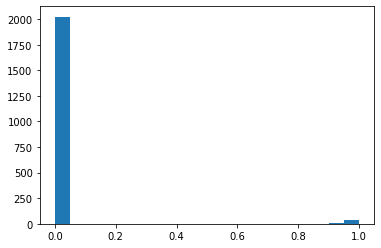

In [17]:
import matplotlib.pyplot as plt
plt.hist(train_marginals, bins=20)
plt.show()

Now that we have learned the generative model, we will measure its performances using the provided test set

In [18]:
# Load test-set first
reload_external_labels(session, HW_DIR / "gold_labels.test.json")
L_gold_dev = load_gold_labels(session, annotator_name='gold', split=1)

AnnotatorLabels created: 0
AnnotatorLabels created: 0


In [19]:
L_dev = labeler.apply_existing(split=1)
tp, fp, tn, fn = gen_model.error_analysis(session, L_dev, L_gold_dev)

Clearing existing...
Running UDF...
[========================================] 100%

Scores (Un-adjusted)
Pos. class accuracy: 0.778
Neg. class accuracy: 0.986
Precision            0.824
Recall               0.778
F1                   0.8
----------------------------------------
TP: 14 | FP: 3 | TN: 206 | FN: 4



Get detailed statistics of LFs learned by the model

In [20]:
L_dev.lf_stats(session, L_gold_dev, gen_model.learned_lf_stats()['Accuracy'])

,j,Coverage,Overlaps,Conflicts,TP,FP,FN,TN,Empirical Acc.,Learned Acc.
LF_distance,0,1.0,1.0,0.748899,4,83,14,126,0.572687,0.672184
LF_hash,1,1.0,1.0,0.748899,10,109,8,100,0.484581,0.523581
LF_right_detect,2,1.0,1.0,0.748899,17,9,1,200,0.955947,0.974169
LF_combined_refined,3,1.0,1.0,0.748899,13,2,5,207,0.969163,0.977456
LF_distant_supervision,4,1.0,1.0,0.748899,2,1,16,208,0.925110,0.977791


You might want to look at some examples in one of the error buckets to improve your LFs. For example, below is one of the false negatives that we did not correctly label as true mentions

In [21]:
SentenceNgramViewer(fn, session)

<IPython.core.display.Javascript object>

SentenceNgramViewer(cids=[[[2], [0], [1]], [[3]]], html='<head>\n<style>\nspan.candidate {\n    background-col…

## Task 1.4. Training an End Extraction Model

In this final task, we'll use the noisy training labels we generated to train our end extraction model. In particular, we will be training a Bi-LSTM.

In [22]:
train_cands = session.query(Education).filter(Education.split == 0).order_by(Education.id).all()
dev_cands   = session.query(Education).filter(Education.split == 1).order_by(Education.id).all()
test_cands  = session.query(Education).filter(Education.split == 2).order_by(Education.id).all()

In [23]:
from snorkel.annotations import load_gold_labels

L_gold_dev  = load_gold_labels(session, annotator_name='gold', split=1)
L_gold_test = load_gold_labels(session, annotator_name='gold', split=2)

Try tuning the hyper-parameters below to get your best F1 score

In [24]:
# ** STUDENT CODE

# TODO: tune your hyper-parameters for best results

from snorkel.learning.pytorch import LSTM

train_kwargs = {
    'lr':            0.009, # learning rate of the model
    'embedding_dim': 70,   # size of the feature vector
    'hidden_dim':    60,   # number of nodes in each layer in the model
    'n_epochs':      11,   # number of training epochs
    'dropout':       0.2,  # dropout rate (during learning)
    'batch_size':    70,   # training batch size
    'seed':          281
}

lstm = LSTM(n_threads=None)
lstm.train(train_cands, train_marginals, X_dev=dev_cands, Y_dev=L_gold_dev, **train_kwargs)

[LSTM] Training model
[LSTM] n_train=2074  #epochs=11  batch size=70


/Users/crxon/558/env/lib/python3.7/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


[LSTM] Epoch 1 (4.98s)	Average loss=0.162053	Dev F1=0.00
[LSTM] Epoch 2 (10.52s)	Average loss=0.116270	Dev F1=0.00
[LSTM] Epoch 3 (16.60s)	Average loss=0.116469	Dev F1=0.00
[LSTM] Epoch 4 (22.75s)	Average loss=0.113216	Dev F1=0.00
[LSTM] Epoch 5 (29.10s)	Average loss=0.090246	Dev F1=0.00
[LSTM] Epoch 6 (35.39s)	Average loss=0.049010	Dev F1=19.05
[LSTM] Epoch 7 (41.54s)	Average loss=0.032666	Dev F1=57.14
[LSTM] Epoch 8 (47.82s)	Average loss=0.029918	Dev F1=53.85
[LSTM] Epoch 9 (54.20s)	Average loss=0.026681	Dev F1=57.14
[LSTM] Epoch 10 (60.37s)	Average loss=0.021817	Dev F1=60.00
[LSTM] Model saved as <LSTM>
[LSTM] Epoch 11 (66.57s)	Average loss=0.021602	Dev F1=51.61
[LSTM] Training done (66.87s)
[LSTM] Loaded model <LSTM>


**Report performance of your final extractor**

In [25]:
p, r, f1 = lstm.score(test_cands, L_gold_test)
print("Prec: {0:.3f}, Recall: {1:.3f}, F1 Score: {2:.3f}".format(p, r, f1))

Prec: 0.609, Recall: 0.400, F1 Score: 0.483


In [26]:
tp, fp, tn, fn = lstm.error_analysis(session, test_cands, L_gold_test)

Scores (Un-adjusted)
Pos. class accuracy: 0.4
Neg. class accuracy: 0.982
Precision            0.609
Recall               0.4
F1                   0.483
----------------------------------------
TP: 14 | FP: 9 | TN: 493 | FN: 21



Use your new model to extract relation in testing documents, and save it to JSON files.

In [27]:
# ** STUDENT CODE

# TODO: change to your name
save_predicted_relations(HW_DIR / "Zongdi_Xu_hw05_extracted_relation.test.json", test_cands, lstm.predictions(test_cands))